In [18]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, mean_squared_error
from sklearn.preprocessing import StandardScaler,OneHotEncoder, LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA,FastICA
import pandas as pd
import numpy as np
import sys
sys.path.append('C:\\Users\\april\\CS7641_MachineLearning\\assignment1')
from utils.encoder import feature_encode_categorical, onehot_encoder, target_encoder
from load_data import train_test_generate
from model_train_eval import fit, evaluate
import time
import requests
import io
from sklearn.model_selection import train_test_split
import json

import zipfile

In [2]:
%matplotlib inline

In [15]:
df = pd.read_csv('heart.csv')

In [16]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [187]:
df.shape

(303, 14)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1), df['target'], test_size = .2, random_state=10) 

In [20]:
scaler = StandardScaler()
X_train_trans = scaler.fit_transform(X_train)
X_test_trans = scaler.transform(X_test)

In [21]:
# for visualization
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train_trans)
X_train['pca-one'] = pca_result[:,0]
X_train['pca-two'] = pca_result[:,1] 
X_train['pca-three'] = pca_result[:,1] 
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.21254631 0.11401925 0.09538683]


In [22]:
df.shape

(303, 14)

### K-Means Clustering with All Features

In [139]:
import seaborn as sns
rndperm = np.random.permutation(df.shape[0])

def plot_kmeans_cluster(n_cluster, Xtrain, Xtest, seed, init, name):
    kmeans = kmeans_clustering(n_cluster, Xtrain, seed, init)
    X_train[name] = kmeans.labels_
    X_test[name] = kmeans.predict(Xtest)
    
    #plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="pca-one", y="pca-two",
        hue=name,
        palette=sns.color_palette("hls", n_cluster),
        data=X_train.loc[rndperm,:],
        legend="full",
        alpha=0.9,
        s = 100
    )
    
    return kmeans

In [24]:
def kmeans_clustering(n_clusters, X,  seed=42, init="random" ):
    kmeans = KMeans(
            init=init,
            n_clusters=n_clusters,
            n_init=10,
            max_iter=300,
            random_state=seed
        )
    kmeans.fit(X)
    return kmeans

In [25]:
def get_metrics(kmeans,X):
    inertia = kmeans.inertia_
    
    dists = euclidean_distances(kmeans.cluster_centers_)
    tri_dists = dists[np.triu_indices(5, 1)]
    max_dist, avg_dist, min_dist = tri_dists.max(), tri_dists.mean(), tri_dists.min()
    
    sihouette_score = silhouette_score(X, kmeans.labels_, sample_size=1000)
    return {'inertia': inertia,
           'intra': (max_dist, avg_dist, min_dist), 
            'sihouette_score': sihouette_score}


In [10]:
kmeans = kmeans_clustering(8, X_train_trans)
X_train['kmeans_cluster'] = kmeans.labels_
X_test['kmeans_cluster'] = kmeans.predict(X_test_trans)

In [13]:
X_train.columns

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_0', 'workclass_1', 'workclass_2',
       'workclass_3',
       ...
       'native-country_36', 'native-country_37', 'native-country_38',
       'native-country_39', 'native-country_40', 'native-country_41',
       'pca-one', 'pca-two', 'pca-three', 'kmeans_cluster'],
      dtype='object', length=112)

In [11]:
get_metrics(kmeans, X_train_trans)

{'inertia': 2183028.0571794333,
 'intra': (18.918729501143893, 11.177176335263269, 3.6809401570130778),
 'sihouette_score': 0.07734575428309146}

#### Choose optimal clusters 

In [103]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d(name):
    ax = plt.figure(figsize=(16,10)).gca(projection='3d')
    ax.scatter(
        xs=X_train.loc[rndperm,:]["pca-one"], 
        ys=X_train.loc[rndperm,:]["pca-two"], 
        zs=X_train.loc[rndperm,:]["pca-three"], 
        c=X_train.loc[rndperm,:][name], 
        #cmap=''
    )
    ax.set_xlabel('pca-one')
    ax.set_ylabel('pca-two')
    ax.set_zlabel('pca-three')
    plt.show()

In [27]:

def elbow_method(k_list, X, random_state_list, save=False, filename=None, **kmeans_kwargs):

    # A list holds the SSE values for each k
    sse_smart = []
    
    for k in k_list:
        total = 0
        for r in random_state_list:
            kmeans = KMeans(n_clusters=k, random_state =r, **kmeans_kwargs)
            start = time.time()
            kmeans.fit(X)
            end = time.time()
            score = kmeans.inertia_
            print (k, r, score, end-start)
            
            total += score
            
        sse_smart.append(total/len(random_state_list))
        
    plt.style.use("fivethirtyeight")
    plt.plot(k_list, sse_smart, ls='--',marker='D',  markerfacecolor="r")
    plt.xticks(k_list)
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()
    if save:
        plt.savefig(filename)
        
    return sse_smart

In [28]:
def sihouette(k_list, X, random_state_list, save=False, filename=None, **kmeans_kwargs):
    silhouette_coefficients_smart = []

    # Notice you start at 2 clusters for silhouette coefficient
    for k in k_list:
        total = 0
        for r in  random_state_list:
            kmeans = KMeans(n_clusters=k, random_state = r, **kmeans_kwargs)
            start = time.time()
            kmeans.fit(X)
            end = time.time()
            score = silhouette_score(X, kmeans.labels_, sample_size = len(df)//10)
            total += score
            print (k, r, score, end-start)
        silhouette_coefficients_smart.append(total/len(random_state_list))
    
    plt.style.use("fivethirtyeight")
    plt.plot(k_list, silhouette_coefficients_smart,ls='--',marker='D',  markerfacecolor="r" )
    plt.xticks(k_list)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()
    return silhouette_coefficients_smart

In [31]:
k_list = range(2,21)
random_state_list = [0, 42, 100]

5 0 2220.4675410938503 0.04480266571044922
5 42 2209.1367077577356 0.050830841064453125
5 100 2200.2148537931175 0.08537840843200684
10 0 1829.2260681276534 0.0906989574432373
10 42 1839.3390529995106 0.07277989387512207
10 100 1867.5228212520988 0.09667778015136719
15 0 1615.9149121928622 0.09823131561279297
15 42 1634.7447843656223 0.10312104225158691
15 100 1641.929559840685 0.09794235229492188
20 0 1479.884686481735 0.15004181861877441
20 42 1464.0336657164219 0.12657499313354492
20 100 1454.082519061166 0.18438339233398438
25 0 1309.8797272554705 0.3063492774963379
25 42 1322.7510970744538 0.26766228675842285
25 100 1317.379495387224 0.25204038619995117
30 0 1216.81134319444 0.26662445068359375
30 42 1208.755931236637 0.25553464889526367
30 100 1202.05835976174 0.37824153900146484
35 0 1116.3817151934793 0.3452494144439697
35 42 1119.0813895335455 0.3143627643585205
35 100 1119.193567895094 0.29907846450805664
40 0 1030.30866718679 0.28803467750549316
40 42 1026.5373062545088 0.30

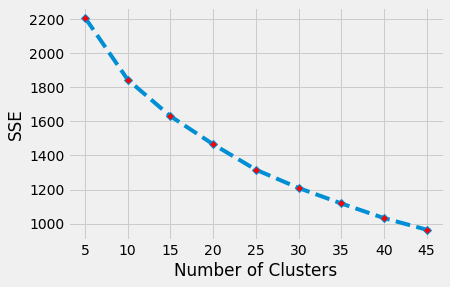

In [35]:
k_list = range(5, 50,5)
kmeans_kwargs = {
    "init": "k-means++",
      "n_init": 10,
        "max_iter": 300
   }
sse_smart = elbow_method(k_list = k_list, X=X_train_trans, random_state_list=[0, 42, 100], **kmeans_kwargs)

2 0 0.20489939327781684 0.02591419219970703
2 42 0.1119668658134976 0.02308034896850586
2 100 0.19134303111722034 0.02831125259399414
3 0 0.11499377239264376 0.05083417892456055
3 42 0.1655108075854798 0.03289055824279785
3 100 0.08065134571066138 0.0777435302734375
4 0 0.07377825803700912 0.07973241806030273
4 42 0.08925781804426473 0.05182695388793945
4 100 0.09008509415809891 0.07674455642700195
5 0 0.04787889909966525 0.06479001045227051
5 42 0.10118785493928577 0.07555627822875977
5 100 0.09668842729727609 0.08873534202575684
6 0 0.05826303119643939 0.0796816349029541
6 42 0.03969519832587591 0.12259054183959961
6 100 0.1089776340925259 0.10240387916564941
7 0 0.07660290088161593 0.13255715370178223
7 42 0.08001493490508764 0.20935487747192383
7 100 0.06118905441429389 0.19139552116394043
8 0 0.0765942137420905 0.1823902130126953
8 42 0.04291734886555582 0.17541790008544922
8 100 0.0809716064069276 0.17242813110351562
9 0 0.06363677625031712 0.20631909370422363
9 42 0.127585498653

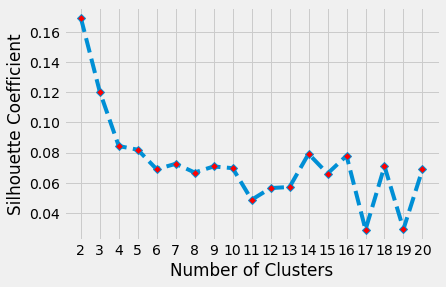

In [33]:
kmeans_kwargs = {
    "init": "k-means++",
      "n_init": 10,
        "max_iter": 300
      
   }

sihouette_smart_10 = sihouette(range(2,21), X_train_trans, random_state_list,  **kmeans_kwargs)

In [36]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train_trans)
X_train['pca-one'] = pca_result[:,0]
X_train['pca-two'] = pca_result[:,1] 
X_train['pca-two'] = pca_result[:,1] 
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.21254631 0.11401925 0.09538683]


C:\Users\april\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


KMeans(n_clusters=2, random_state=42)

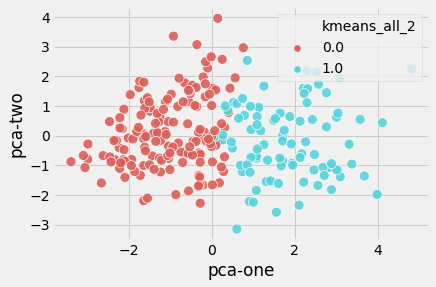

In [140]:
plot_kmeans_cluster(n_cluster=2, Xtrain=X_train_trans, Xtest=X_test_trans, seed=42, init='k-means++', name='kmeans_all_2')

In [188]:
train_ori = df.iloc[X_train.index]
ori_clus = pd.concat([train_ori,X_train.iloc[:, 108:] ], axis=1)
def get_percent_plot(metric):
    c = pd.DataFrame(ori_clus[ori_clus.y == ' >50K'][metric].value_counts())
    c.reset_index()
    c['y'] = 1
    d = pd.DataFrame(ori_clus[ori_clus.y == ' <=50K'][metric].value_counts())
    d['y'] = 0
    e = pd.concat([c.reset_index(), d.reset_index()])
    e['cluster'] = e['index']
    eall=e.groupby('cluster').sum().reset_index()[['cluster', metric]]

    com = pd.merge(e, eall, on='cluster')
    com['percentage'] = com[metric+'_x']/com[metric +'_y']
    sns.barplot(x="cluster", y="percentage", hue = 'y', data=com)
    return com

In [191]:
X_train['kmeans_all_2'].value_counts()

0    154
1     88
Name: kmeans_all_2, dtype: int64

In [192]:
X_train.y.value_counts()

1    139
0    103
Name: y, dtype: int64

In [190]:
X_train['y'] = y_train

In [196]:
X_train[X_train.kmeans_all_2 != X_train.y].shape

(197, 32)

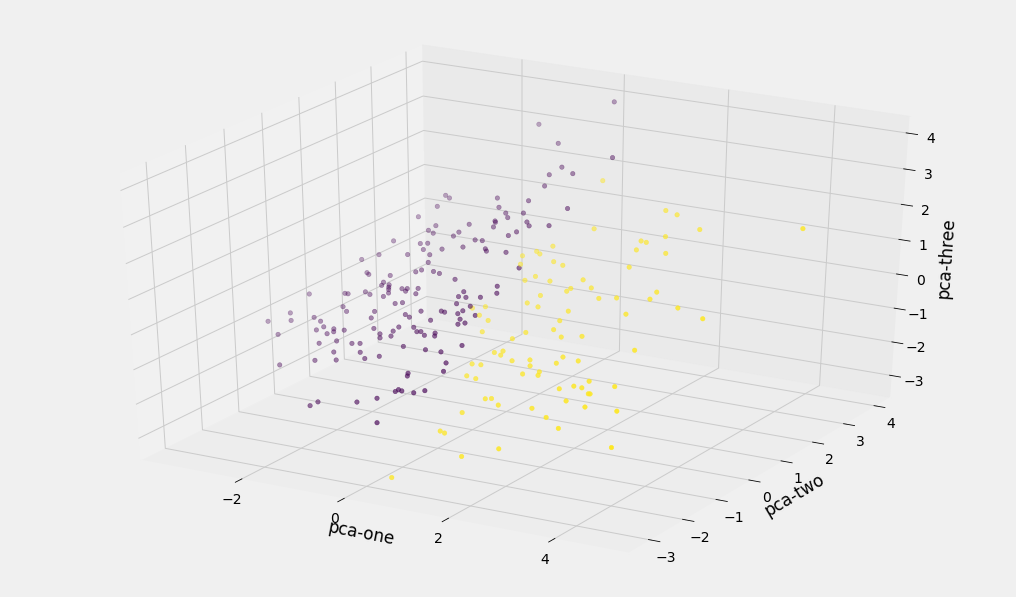

In [141]:
plot_3d('kmeans_all_2')

In [72]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(df['income'])

In [73]:
true_labels

array([0, 0, 0, ..., 0, 0, 1])

### EM with All features

In [134]:
import seaborn as sns
#covariance_type=covariance_type, init_params='kmeans'

rndperm = np.random.permutation(df.shape[0])
def GMM_cluster(n_components, X, random_state, save=False, filename=None, plot=False, **gmm_kwargs):
    
    em_model = GaussianMixture(n_components=n_components, random_state=random_state, **gmm_kwargs )
    em_model.fit(X)
    if plot:
        X_train['gmm_cluster'] = em_model.predict(X)
        plt.figure(figsize=(16,10))
        sns.scatterplot(
            x="pca-one", y="pca-two",
            hue="gmm_cluster",
            palette=sns.color_palette("hls", n_components),
            data=X_train.loc[rndperm,:],
            legend="full",
            alpha=0.9,
            s= 100
        )
    return em_model
    

In [135]:
def choose_n_components_GMM(n_components, X, random_state_list, save=False, filename=None, **gmm_kwargs):
    aic_score = []
    bic_score = []
    for n in n_components:
        total_aic = 0 
        total_bic = 0
        for r in random_state_list:
            em = GaussianMixture(n, random_state =r, **gmm_kwargs)
            start = time.time()
            em.fit(X)
            end = time.time()
            score_aic = em.aic(X)
            score_bic = em.bic(X)
            total_aic += score_aic
            total_bic += score_bic
            print (n, r, total_aic, total_bic, end-start)
        aic_score.append(total_aic/len(random_state_list))
        bic_score.append(total_bic/len(random_state_list))
        

    plt.plot(n_components, bic_score, label='BIC',ls='--',marker='D')
    plt.plot(n_components, aic_score, label='AIC',ls='--',marker='D')
    plt.legend(loc='best')
    plt.xlabel('n_components');
    return aic_score, bic_score

2 0 7254.448672048722 7983.63665681547 0.04484724998474121
2 42 14508.897344097359 15967.273313630854 0.01195979118347168
2 100 19982.527831230058 22170.091785530298 0.019895553588867188
3 0 5631.706338941093 6727.232784954293 0.022957324981689453
3 42 10890.10369294147 13081.15658496787 0.011960268020629883
3 100 16564.39115230192 19850.97049034152 0.017982959747314453
4 0 5242.943364340657 6704.808271600309 0.0249176025390625
4 42 7895.956559609178 10819.686374128481 0.02496957778930664
4 100 12266.99141250107 16652.586134280024 0.029898881912231445
5 0 1848.0331443911246 3676.2365128972283 0.04584932327270508
5 42 4002.6091838233783 7659.015920835585 0.02591419219970703
5 100 7010.462389187644 12495.072494705953 0.03189253807067871
6 0 2421.122297722939 4615.664127475495 0.05481910705566406
6 42 4402.541185393978 8791.62484489909 0.03189659118652344
6 100 9101.321519733585 15684.947008991252 0.04086494445800781
7 0 1536.0810399759669 4096.961330974975 0.07873201370239258
7 42 3186.8

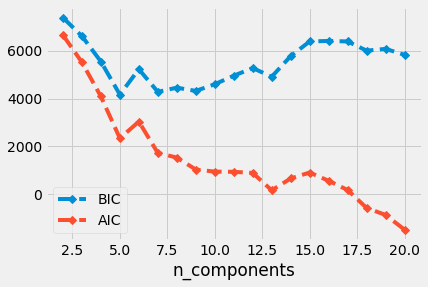

In [43]:
gmm_kwargs = {
    "init_params": "kmeans",
      "covariance_type": "full"
      
   }
aic_score, bic_score = choose_n_components_GMM(n_components = range(2, 21), X=X_train_trans, random_state_list=[0, 42, 100], **gmm_kwargs)

2 0 8646.470671521402 8747.649865579946 0.01841568946838379
2 42 17293.07129787234 17495.42968598943 0.009966850280761719
2 100 25939.576956725425 26243.114538901063 0.009966850280761719
3 0 8569.340453420347 8722.853713371242 0.010962247848510742
3 42 17185.374405706494 17492.400925608283 0.012956380844116211
3 100 25791.800047528955 26252.33982738164 0.013957500457763672
4 0 8557.575643154254 8763.422968997498 0.014950275421142578
4 42 17115.841791961513 17527.536443648 0.012959718704223633
4 100 25599.37415100656 26216.916128536293 0.01299142837524414
5 0 8442.014654833552 8700.196046569148 0.022923946380615234
5 42 16915.82011574749 17432.182899218682 0.01395416259765625
5 100 25358.400924057678 26132.945099264467 0.03243660926818848
6 0 8412.417617507721 8722.933075135667 0.034885406494140625
6 42 16822.053249273 17443.084164528893 0.04037880897521973
6 100 25253.705025436553 26185.25139832039 0.037873029708862305
7 0 8396.347093535995 8759.196617056288 0.02791142463684082
7 42 16

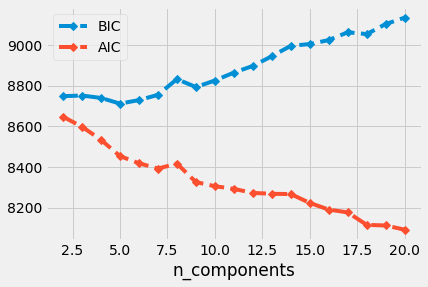

In [65]:
# ['spherical', 'tied', 'diag', 'full']
gmm_kwargs = {
    "init_params": "kmeans",
      "covariance_type": "spherical"
      
   }
aic_score, bic_score = choose_n_components_GMM(n_components = range(2, 21), X=X_train_trans, random_state_list=[0, 42, 100], **gmm_kwargs)

2 0 5596.999862130067 5781.913561616372 0.01002812385559082
2 42 11193.999724260135 11563.827123232744 0.0069751739501953125
2 100 16207.12253510887 16761.863633567784 0.00901174545288086
3 0 3617.8496418915556 3896.9646599840908 0.011909246444702148
3 42 6382.921200595969 6941.151236781039 0.016944169998168945
3 100 11774.00985865213 12611.354912929737 0.013987302780151367
4 0 4529.091768664679 4902.4081053634445 0.009930610656738281
4 42 6842.19905386022 7588.8317272577515 0.011953592300415039
4 100 10392.098152647399 11512.047162743696 0.012956619262695312
5 0 1119.241064317541 1586.758719622537 0.01495051383972168
5 42 2266.1397645056895 3201.1750751156815 0.015971660614013672
5 100 4738.607852542175 6141.160818457163 0.014990568161010742
6 0 530.635607089833 1092.3545810010596 0.016944169998168945
6 42 1291.9093847897577 2415.347332612211 0.011962413787841797
6 100 3842.847216143595 5528.004137877275 0.02790999412536621
7 0 1401.3469040196276 2057.2671965370846 0.02093386650085449

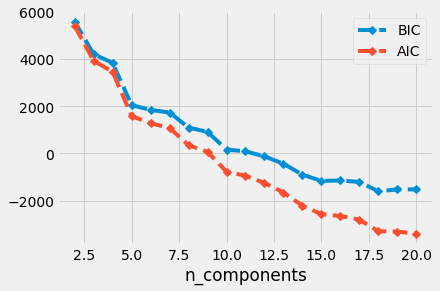

In [73]:
# ['spherical', 'tied', 'diag', 'full']
gmm_kwargs = {
    "init_params": "kmeans",
      "covariance_type": "diag"
      
   }
aic_score, bic_score = choose_n_components_GMM(n_components = range(2, 21), X=X_train_trans, random_state_list=[0, 42, 100], **gmm_kwargs)

In [132]:
def plot_GMM_cluster(n_components, Xtrain, Xtest, random_state, name, save=False, filename=None, plot=False, **gmm_kwargs):
    
    em_model = GaussianMixture(n_components=n_components, random_state=random_state, **gmm_kwargs )
    em_model.fit(Xtrain)
    if plot:
        X_train[name] = em_model.predict(Xtrain)
        X_test[name] = em_model.predict(Xtest)
        plt.figure(figsize=(8,5))
        ax = sns.scatterplot(
            x="pca-one", y="pca-two",
            hue=name,
            palette=sns.color_palette("hls", n_components),
            data=X_train.loc[rndperm,:],
           # data = X_train[X_train[name].isin(em_model.weights_.argsort()[::-1][:5])],
            #legend="",
            alpha=0.9,
            s = 100
        )
        plt.setp(ax.get_legend().get_texts(), fontsize='8') # for legend text
        plt.setp(ax.get_legend().get_title(), fontsize='10') # for legend title
    return em_model

C:\Users\april\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


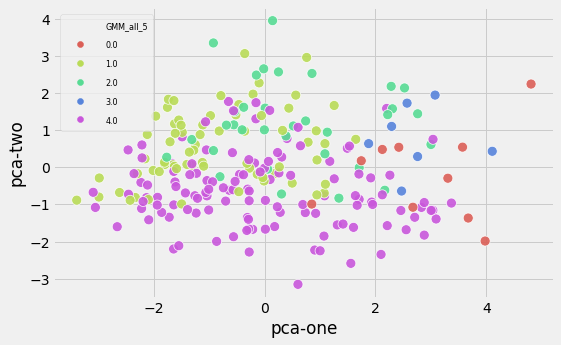

In [142]:
# plot GMM cluster based on optimal number
gmm_kwargs = {
    "init_params": "kmeans",
      "covariance_type": "full"
      
   }
em_model_all_20 = plot_GMM_cluster(5, X_train_trans, X_test_trans,  42, 'GMM_all_5', save=False, filename=None, plot=True, **gmm_kwargs)

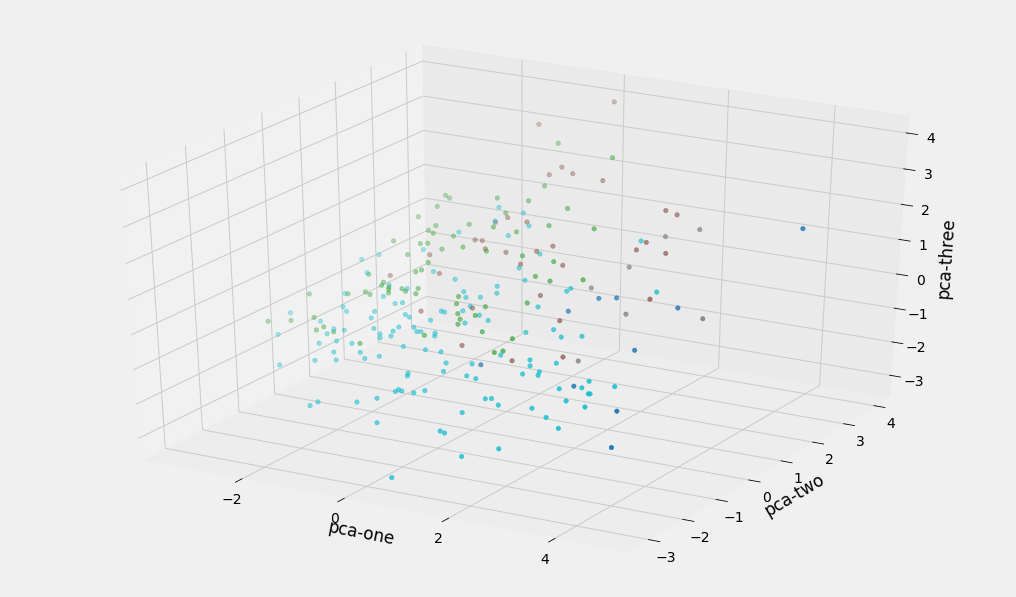

In [71]:
plot_3d('GMM_all_5')

C:\Users\april\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


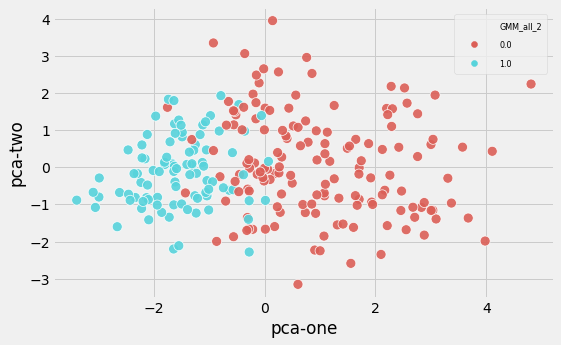

In [143]:
# plot GMM cluster based on optimal number
gmm_kwargs = {
    "init_params": "kmeans",
      "covariance_type": "spherical"
      
   }
   
em_model_all_20 = plot_GMM_cluster(2, X_train_trans, X_test_trans,  42, 'GMM_all_2', save=False, filename=None, plot=True, **gmm_kwargs)

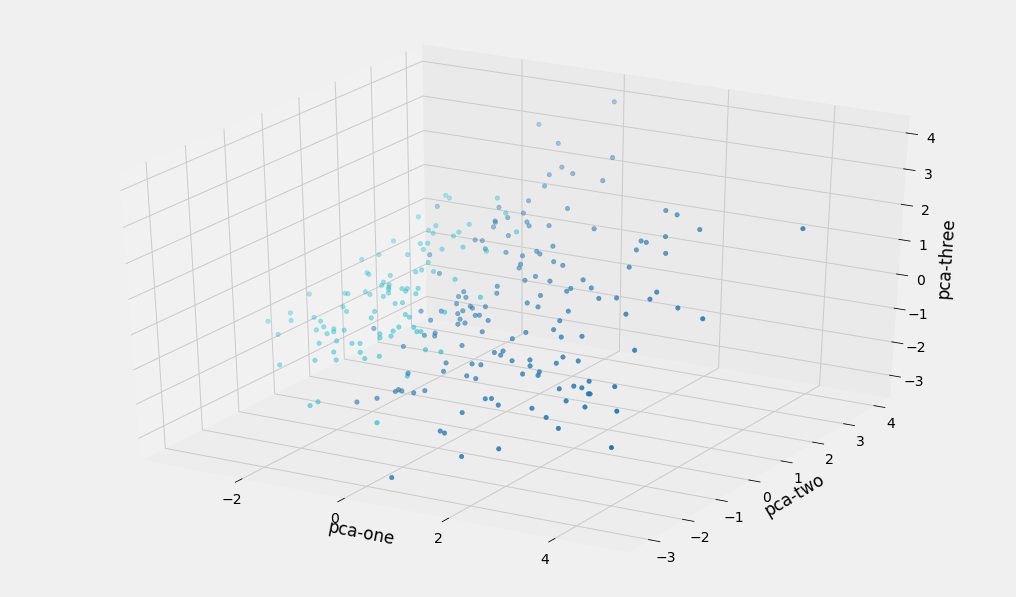

In [72]:
plot_3d('GMM_all_2')

C:\Users\april\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


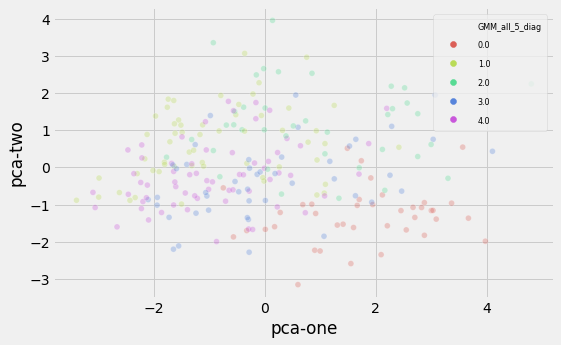

In [74]:
# plot GMM cluster based on optimal number
gmm_kwargs = {
    "init_params": "kmeans",
      "covariance_type": "diag"
      
   }
em_model_all_5 = plot_GMM_cluster(5, X_train_trans, X_test_trans,  42, 'GMM_all_5_diag', save=False, filename=None, plot=True, **gmm_kwargs)

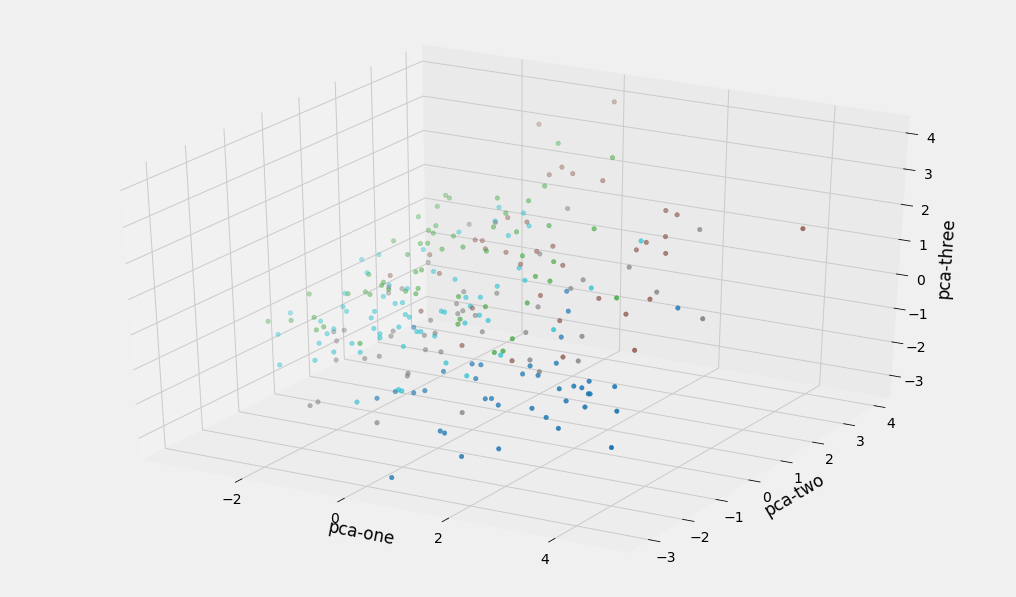

In [75]:
plot_3d('GMM_all_5_diag')

In [79]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(y_train)

In [81]:
#label_encoder = LabelEncoder()
#true_labels = label_encoder.fit_transform(y_train['income'])
print (adjusted_rand_score(true_labels, X_train['GMM_all_2']))
#print (adjusted_rand_score(true_labels, X_train['GMM_all_8']))
#print (adjusted_rand_score(true_labels, X_train['GMM_all_20']))

0.16662198169821288


In [80]:
print (adjusted_rand_score(true_labels, X_train['kmeans_all_2']))
#print (adjusted_rand_score(true_labels, X_train['kmeans_all_300']))

0.39122009015162335


In [197]:
X_train[X_train['kmeans_all_2'] == 0].y.value_counts()

1    124
0     30
Name: y, dtype: int64

In [200]:
73/88

0.8295454545454546

In [198]:
X_train[X_train['kmeans_all_2'] == 1].y.value_counts()

0    73
1    15
Name: y, dtype: int64

### Feature Reduction

#### Principal Component Aanalysis

In [144]:
def choose_component_for_PCA(X):
    pca = PCA()
    pca.fit(X)
    variance = pca.explained_variance_ratio_
    plt.figure(figsize= ( 10, 8))
    plt.plot(range(1, X.shape[1]+1), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
    plt.title('Explained Variance by Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    return variance

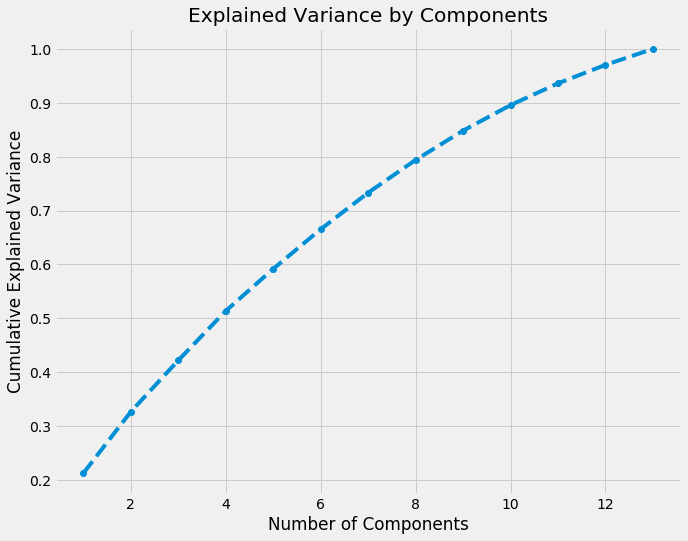

In [83]:
variance = choose_component_for_PCA(X_train_trans)

In [84]:
variance

array([0.21254631, 0.11401925, 0.09538683, 0.09168367, 0.07807823,
       0.07360761, 0.06777899, 0.06078414, 0.05442763, 0.04738486,
       0.04040201, 0.03430816, 0.02959231])

In [85]:
pca = PCA()
pca.fit(X_train_trans)
variance = pca.explained_variance_ratio_

(array([4., 2., 3., 2., 1., 0., 0., 0., 0., 1.]),
 array([0.02959231, 0.04788771, 0.06618311, 0.08447851, 0.10277391,
        0.12106931, 0.13936471, 0.15766011, 0.17595551, 0.19425091,
        0.21254631]),
 <a list of 10 Patch objects>)

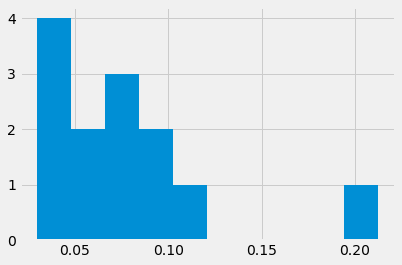

In [86]:
plt.hist(variance)

In [87]:
len(variance)

13

In [88]:
# get optimal 

def pca_input(n, X_train, X_test):
    pca = PCA(n_components=n)
    pca.fit(X_train)
    PCA_X_train = pca.transform(X_train)
    PCA_X_test = pca.transform(X_test)
    return PCA_X_train, PCA_X_test

In [89]:
PCA_X_train, PCA_X_test = pca_input(7, X_train_trans, X_test_trans)

In [90]:
PCA_X_train

array([[-1.0505304 ,  0.46890869, -0.18089823, ..., -1.21168481,
        -0.9521369 , -0.96124498],
       [-1.16403037,  0.88221566,  0.0202848 , ..., -1.83306355,
        -0.83511423,  0.22638691],
       [ 1.53045585,  0.57256892,  0.58160779, ..., -0.83844188,
         1.50829747, -1.03699693],
       ...,
       [-1.12251297,  0.13094547,  2.03413987, ...,  0.21292213,
        -0.34647404, -0.18475324],
       [-2.98936063, -0.79958957,  0.61876117, ...,  0.08405028,
        -0.10204533,  0.95060027],
       [ 0.68913255, -1.00127757, -1.03742623, ..., -1.06246427,
         1.51580318, -0.46353524]])

In [129]:
# choose k for K-means clustering

5 0 1400.2890538070792 0.05282711982727051
5 42 1406.4281648064532 0.06178998947143555
5 100 1397.4505258518884 0.049832820892333984
10 0 1094.4192199312017 0.11352109909057617
10 42 1085.1270385442376 0.08372282981872559
10 100 1101.1945394869426 0.10382246971130371
15 0 930.4596114461759 0.11162900924682617
15 42 906.0941884088523 0.11165165901184082
15 100 898.8937738477192 0.11561918258666992
20 0 784.960111556596 0.15847516059875488
20 42 785.595157902902 0.19936394691467285
20 100 784.6275820893121 0.18737292289733887
25 0 688.4769345939716 0.22401118278503418
25 42 692.0452825691756 0.2782738208770752
25 100 691.6711746074232 0.23557543754577637
30 0 622.4854556967919 0.23134803771972656
30 42 620.6998571262129 0.2630925178527832
30 100 622.9162751252991 0.2820601463317871
35 0 565.4154538291851 0.36777329444885254
35 42 571.1576593271794 0.22031688690185547
35 100 563.4210869386461 0.1918635368347168
40 0 517.2153973475008 0.22974681854248047
40 42 516.2658436694663 0.227241277

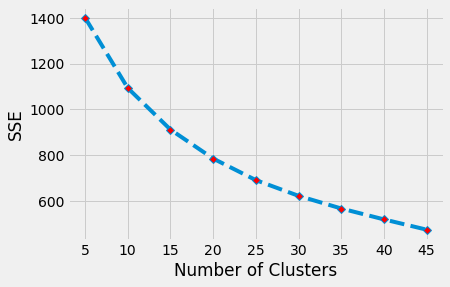

In [91]:
kmeans_kwargs = {
    "init": "k-means++",
      "n_init": 10,
        "max_iter": 300,
      
   }
sse_pca = elbow_method(k_list = range(5, 50, 5), X=PCA_X_train, random_state_list=[0, 42, 100], **kmeans_kwargs)

2 0 0.26932926637096133 0.024921178817749023
2 42 0.18062246743294097 0.02690720558166504
2 100 0.15304929745403903 0.028857707977294922
3 0 0.18151736038689772 0.04285550117492676
3 42 0.1253137517127254 0.03687715530395508
3 100 0.14713415383946418 0.055379629135131836
4 0 0.1669961697021181 0.09269165992736816
4 42 0.09365519548998957 0.08770608901977539
4 100 0.20010129849217165 0.07689070701599121
5 0 0.16287985716993064 0.08493447303771973
5 42 0.08717658738048915 0.07973027229309082
5 100 0.18192528557990195 0.07774162292480469
6 0 0.08863447742443938 0.08571434020996094
6 42 0.11168819791290745 0.10166049003601074
6 100 0.06364597236225167 0.10764241218566895
7 0 0.17569198057191118 0.16783571243286133
7 42 0.026620235297217732 0.15846967697143555
7 100 0.1662925853720483 0.14351916313171387
8 0 0.11932234409918875 0.1006631851196289
8 42 0.13783452951029676 0.08072781562805176
8 100 0.0976867085215114 0.12354087829589844
9 0 0.0720357791152783 0.09174942970275879
9 42 0.048309

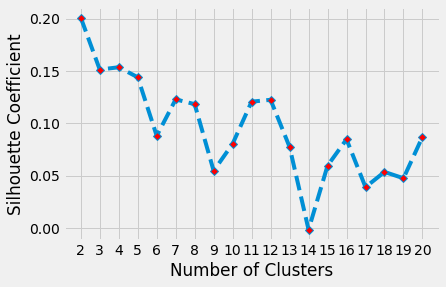

In [92]:
random_state_list=[0, 42, 100]
kmeans_kwargs = {
    "init": "k-means++",
      "n_init": 10,
        "max_iter": 300
      
   }

sihouette_pca_10 = sihouette(range(2,21), PCA_X_train, random_state_list,  **kmeans_kwargs)

C:\Users\april\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


KMeans(n_clusters=2, random_state=42)

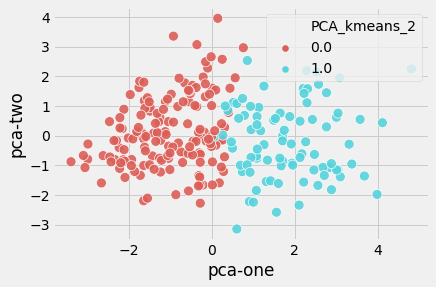

In [145]:
# draw clustering for optimal k for PCA 

plot_kmeans_cluster(n_cluster=2, Xtrain=PCA_X_train, Xtest=PCA_X_test, seed=42, init='k-means++', name='PCA_kmeans_2')

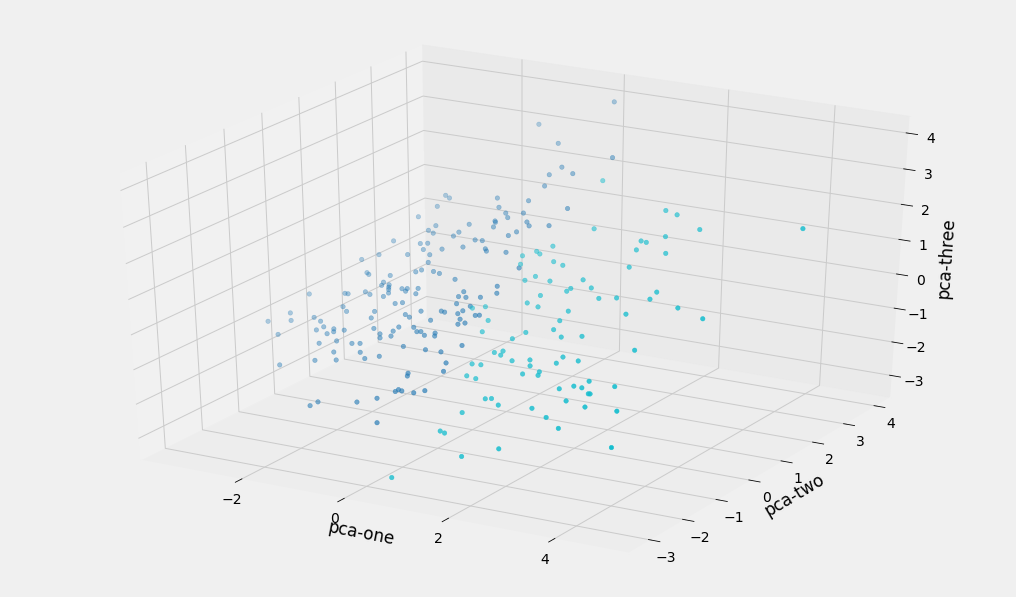

In [94]:
plot_3d('PCA_kmeans_2')

In [95]:
print (adjusted_rand_score(true_labels, X_train['PCA_kmeans_2']))
#print (adjusted_rand_score(true_labels, X_train['PCA_kmeans_3']))

0.38079908652527367


In [96]:
X_train['PCA_kmeans_2'].value_counts()

0    155
1     87
Name: PCA_kmeans_2, dtype: int64

2 0 5177.225079633195 5424.939658190319 0.027906417846679688
2 42 10354.245733778123 10849.674890892373 0.032889604568481445
2 100 15497.45611467496 16240.599850346334 0.03986477851867676
3 0 5083.792557557639 5457.108894256405 0.06828618049621582
3 42 10163.5531878617 10910.185861259231 0.04285764694213867
3 100 15180.927572264347 16300.876582360645 0.04883885383605957
4 0 5031.282499878336 5530.200594718743 0.0548396110534668
4 42 10007.908498958299 11005.744688639112 0.07471418380737305
4 100 14965.872997571107 16462.627282092326 0.10334563255310059
5 0 4974.38253771237 5598.902390694418 0.16377854347229004
5 42 9938.852384339072 11187.892090303167 0.14212512969970703
5 100 14883.343622657463 16756.903181603604 0.08073115348815918
6 0 4961.181606176866 5711.303217300554 0.1331462860107422
6 42 9910.193997692522 11410.437219939899 0.1599879264831543
6 100 14870.104104708667 17120.46893807973 0.06879329681396484
7 0 4919.67532612417 5795.398695389498 0.08673262596130371
7 42 9913.5262

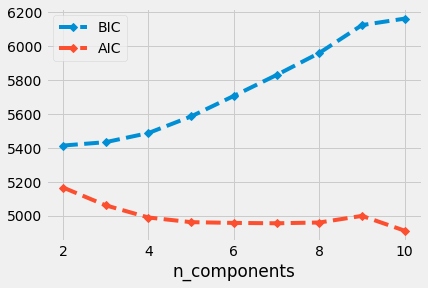

In [97]:
gmm_kwargs = {
    "init_params": "kmeans",
      "covariance_type": "full"
      
   }
aic_score_10, bic_score_10 = choose_n_components_GMM(n_components = range(2, 11), X=PCA_X_train, random_state_list=[0, 42, 100], **gmm_kwargs)

2 0 5179.681967590286 5238.99390893495 0.013910055160522461
2 42 10359.231024660834 10477.854907350162 0.00897073745727539
2 100 15538.886038055352 15716.821862089342 0.009967327117919922
3 0 5126.996227341239 5217.708608221314 0.01694488525390625
3 42 10253.943646198317 10435.368407958465 0.018936872482299805
3 100 15380.932907024022 15653.070049664244 0.01594686508178711
4 0 5111.652365852033 5233.765186267517 0.022925138473510742
4 42 10220.479301090718 10464.704941921686 0.02591729164123535
4 100 15337.142966684685 15703.481427931136 0.02990555763244629
5 0 5078.31408848242 5231.827348433314 0.0348811149597168
5 42 10156.364497926803 10463.391017828591 0.041860342025756836
5 100 15259.046223246354 15719.586003099037 0.031891584396362305
6 0 5093.41161097852 5278.325310464825 0.026905298233032227
6 42 10170.20769772599 10540.0350966986 0.0279080867767334
6 100 15216.849650365271 15771.590748824186 0.031900644302368164
7 0 5093.029033429353 5309.343172451067 0.036875247955322266
7 42

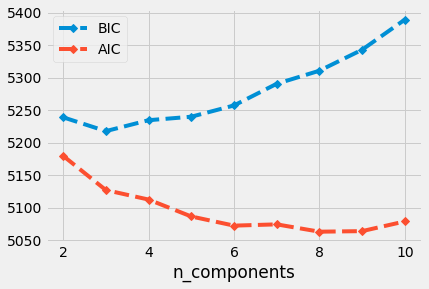

In [99]:
gmm_kwargs = {
    "init_params": "kmeans",
      "covariance_type": "spherical"
      
   }
aic_score_10, bic_score_10 = choose_n_components_GMM(n_components = range(2, 11), X=PCA_X_train, random_state_list=[0, 42, 100], **gmm_kwargs)

C:\Users\april\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


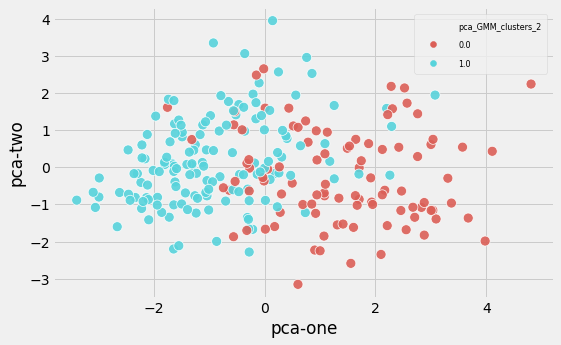

In [202]:
# plot GMM cluster based on optimal number
gmm_kwargs = {
    "init_params": "kmeans",
      "covariance_type": "full"
      
   }
em_model = plot_GMM_cluster(2, PCA_X_train, PCA_X_test, 42, 'pca_GMM_clusters_2', save=False, filename=None, plot=True, **gmm_kwargs)

#### Indepdent Component Analysis 

In [147]:
from scipy.stats import kurtosis
def choose_n_ICA(n_components, X):
    
    kurtosis_scores = []
    avg_kurtosis = [np.mean(kurtosis(FastICA(n_components=n).fit_transform(X)))
              for n in n_components]

    plt.plot(n_components, avg_kurtosis)
    plt.legend(loc='best')
    plt.xlabel('n_components')
    plt.ylabel('avg kurtosis')
    plt.title('N_components vs Avg Kurtosis')
    return avg_kurtosis

In [148]:
X_train.shape

(242, 24)

In [149]:
X_train.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'pca-one', 'pca-two',
       'pca-three', 'kmeans_all_2', 'GMM_all_5', 'GMM_all_2', 'GMM_all_5_diag',
       'PCA_kmeans_2', 'pca_GMM_clusters_7', 'pca_GMM_clusters_2',
       'pca_GMM_spherical_clusters_3'],
      dtype='object')

No handles with labels found to put in legend.


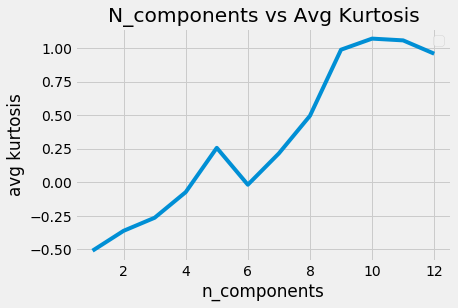

In [150]:
avg_kurtosis = choose_n_ICA(range(1,len(df.columns)-1), X_train_trans)

In [152]:
def ica_input(n, X_train, X_test):
    ica = FastICA(n_components=n)
    ica.fit(X_train)
    ICA_X_train = ica.transform(X_train)
    ICA_X_test = ica.transform(X_test)
    return ICA_X_train, ICA_X_test

In [153]:
ICA_X_train, ICA_X_test = ica_input(8, X_train_trans, X_test_trans)

2 0 7.109920287580422 0.05083107948303223
2 42 7.128636628158933 0.06179499626159668
2 100 7.128636628158933 0.06080293655395508
3 0 6.460304570814103 0.053822994232177734
3 42 6.422498743615765 0.07973432540893555
3 100 6.382728156935811 0.07674360275268555
4 0 5.927911048067883 0.07973384857177734
4 42 5.904265854572633 0.07471632957458496
4 100 5.97251207500264 0.07176065444946289
5 0 5.576739924222177 0.06582188606262207
5 42 5.588672578897169 0.07674407958984375
5 100 5.645783429862461 0.06972742080688477
6 0 5.282818851509061 0.08622360229492188
6 42 5.286767497019262 0.0916895866394043
6 100 5.291791698514286 0.15649151802062988
7 0 5.010243403271486 0.2232530117034912
7 42 5.026540677607176 0.14802980422973633
7 100 5.059866421045387 0.10670113563537598
8 0 4.778412778789526 0.12310338020324707
8 42 4.779074945017545 0.13853812217712402
8 100 4.768530155878438 0.10963320732116699
9 0 4.558654092015255 0.14352178573608398
9 42 4.512211090536496 0.11162686347961426
9 100 4.520486

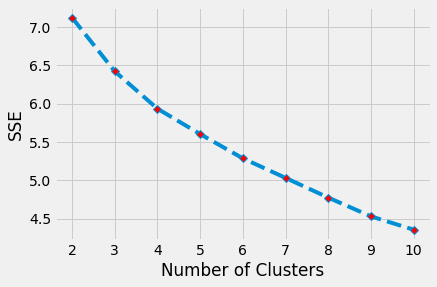

In [154]:
kmeans_kwargs = {
    "init": "k-means++",
      "n_init": 10,
        "max_iter": 300,
      
   }
sse_pca = elbow_method(k_list = range(2,11), X=ICA_X_train, random_state_list=[0, 42, 100], **kmeans_kwargs)

2 0 0.1085650595470936 0.030896425247192383
2 42 0.21204108829881677 0.03593325614929199
2 100 0.20926121625886526 0.03253436088562012
3 0 0.08712329272548398 0.04701638221740723
3 42 0.11864132443332134 0.05486106872558594
3 100 0.12030633696792922 0.09468317031860352
4 0 0.10819930954594623 0.061326026916503906
4 42 0.17507698977920283 0.07471704483032227
4 100 0.09439152714567296 0.05721926689147949
5 0 0.07125958302291474 0.07025003433227539
5 42 0.1311708621442683 0.08225393295288086
5 100 0.04794580401602371 0.06502437591552734
6 0 0.08950932312384759 0.07190775871276855
6 42 0.12235168528140082 0.07938766479492188
6 100 0.04339386358638807 0.0812528133392334
7 0 0.048294837545665076 0.10465073585510254
7 42 0.0932132637966978 0.2058405876159668
7 100 0.014600598995978521 0.1611771583557129
8 0 0.08260946035501969 0.14153075218200684
8 42 0.08087024021058536 0.1305675506591797
8 100 0.10787886009212697 0.12058162689208984
9 0 0.07070966195900429 0.11860394477844238
9 42 0.1024316

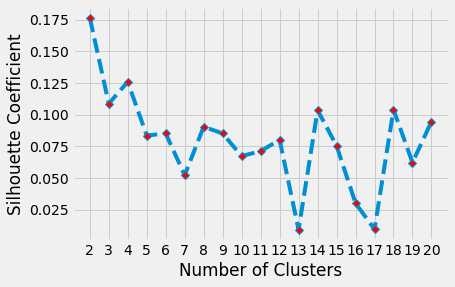

In [155]:
random_state_list=[0, 42, 100]
kmeans_kwargs = {
    "init": "k-means++",
      "n_init": 10,
        "max_iter": 300
      
   }

sihouette_pca_10 = sihouette(range(2,21), ICA_X_train, random_state_list,  **kmeans_kwargs)

C:\Users\april\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


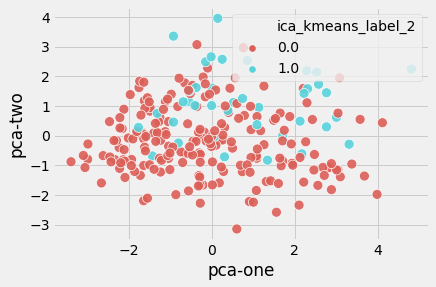

In [159]:
kmeans = plot_kmeans_cluster(2, ICA_X_train, ICA_X_test,42, "k-means++", "ica_kmeans_label_2")

In [160]:
X_train["ica_kmeans_label_2"].value_counts()

0    203
1     39
Name: ica_kmeans_label_2, dtype: int64

2 0 -5374.4520367387995 -5063.936579110854 0.0288698673248291
2 42 -10739.66461037222 -10118.633695116328 0.01993417739868164
2 100 -16104.818614469521 -15173.272241585684 0.017940998077392578
3 0 -5127.801890683666 -4660.28423537867 0.014951229095458984
3 42 -10543.877692578088 -9608.842381968094 0.03783607482910156
3 100 -15988.28174880202 -14585.728782887029 0.01594710350036621
4 0 -5399.962180608154 -4775.442327626107 0.024919748306274414
4 42 -11051.70932792958 -9802.669621965486 0.056807756423950195
4 100 -16483.805346876274 -14610.24578793013 0.03089618682861328
5 0 -5710.788064977769 -4929.266014318671 0.06299257278442383
5 42 -11187.71657781714 -9624.672476498945 0.05980396270751953
5 100 -16737.212685151353 -14392.646533174062 0.06377601623535156
6 0 -5690.522347031339 -4751.9980986951905 0.04887580871582031
6 42 -11150.892699304964 -9273.844202632667 0.05581068992614746
6 100 -16663.86273481403 -13848.289989805582 0.04285454750061035
7 0 -5462.31740310413 -4366.7909570909305

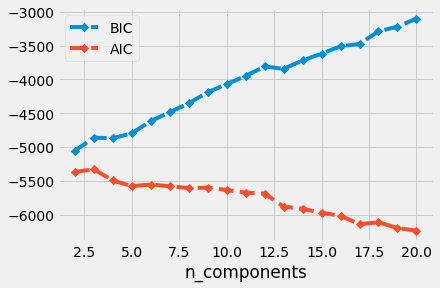

In [161]:
gmm_kwargs = {
    "init_params": "kmeans",
      "covariance_type": "full"
      
   }
aic_score_diag_100, bic_score_diag_100 = choose_n_components_GMM(n_components = range(2, 21), X=ICA_X_train, random_state_list=[0, 42, 100], **gmm_kwargs)

C:\Users\april\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


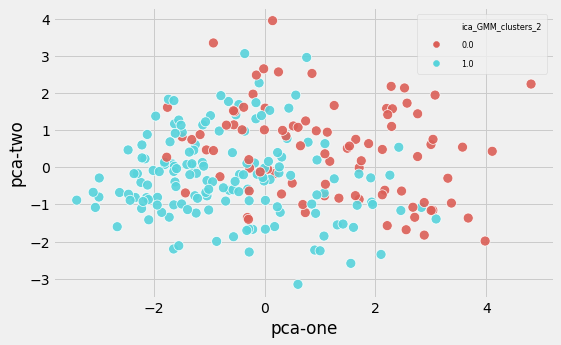

In [162]:
# plot GMM cluster based on optimal number
gmm_kwargs = {
    "init_params": "kmeans",
      "covariance_type": "full"
      
   }
em_model_ica_30 = plot_GMM_cluster(2, ICA_X_train, ICA_X_test, 42, 'ica_GMM_clusters_2', save=False, filename=None, plot=True, **gmm_kwargs)

2 0 -5160.665924868771 -5094.376108071794 0.010955810546875
2 42 -10342.684172517867 -10210.104538923915 0.011959552764892578
2 100 -15506.375218376714 -15307.505767985785 0.00697779655456543
3 0 -5210.217114649449 -5109.037920590906 0.018938779830932617
3 42 -10422.784352254348 -10220.425964137261 0.014950037002563477
3 100 -15616.471818940016 -15312.934236764384 0.012954235076904297
4 0 -5227.06892868502 -5091.000357364909 0.020966529846191406
4 42 -10439.371477976925 -10167.234335336703 0.02287578582763672
4 100 -15647.381937778113 -15239.17622381778 0.030897140502929688
5 0 -5229.581591554237 -5058.6236429725595 0.045845985412597656
5 42 -10470.020454015814 -10128.104556852459 0.029881715774536133
5 100 -15709.868903997458 -15196.995058252425 0.030896425247192383
6 0 -5234.044227173704 -5028.19690133046 0.016942501068115234
6 42 -10485.987620884422 -10074.292969197933 0.02591419219970703
6 100 -15734.947355506742 -15117.40537797701 0.037873268127441406
7 0 -5254.699765560159 -5013.

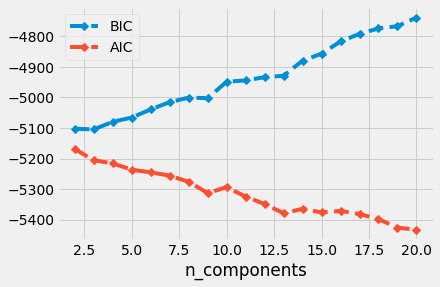

In [165]:
gmm_kwargs = {
    "init_params": "kmeans",
      "covariance_type": "spherical"
      
   }
aic_score_diag_100, bic_score_diag_100 = choose_n_components_GMM(n_components = range(2, 21), X=ICA_X_train, random_state_list=[0, 42, 100], **gmm_kwargs)

#### Random Projection

In [140]:


transformer = random_projection.GaussianRandomProjection(n_components=10)
X_new = transformer.fit_transform(X_train_trans)
X_new.shape

(32561, 10)

In [141]:
inverse_data = np.linalg.pinv(transformer.components_.T)
reconstructed_data = X_new.dot(inverse_data)

In [147]:
mean_squared_error(reconstructed_data, X_train_trans)

0.9076402926195569

In [166]:
import numpy as np
from sklearn import random_projection
from sklearn.random_projection import GaussianRandomProjection
def get_mse_rsa(n, X, r):
    transformer = random_projection.GaussianRandomProjection(n_components=n, random_state=r)
    start = time.time()
    X_new = transformer.fit_transform(X)
    end = time.time()
    
    inverse_data = np.linalg.pinv(transformer.components_.T)
    reconstructed_data = X_new.dot(inverse_data)
    mse = mean_squared_error(reconstructed_data, X)
    return transformer, X_new, mse, end-start

In [167]:
def choose_n_components_rac(n_components, X, random_state_list, save=False, filename=None):
    recons_error_list = []
    for n in n_components:
        total = 0
        for r in random_state_list:
            _, _, mse, elapsed = get_mse_rsa(n, X, r)
            
            total += mse 
            
            print (n, r, mse, elapsed)
            
        recons_error_list.append(total/len(random_state_list))
        
    
    plt.plot(n_components, recons_error_list)
    plt.legend(loc='best')
    plt.xlabel('n_components') 
    plt.ylabel('reconstruction error')
    
    return recons_error_list
            

No handles with labels found to put in legend.


1 0 0.907217478961192 0.00099945068359375
1 42 0.9230390869794974 0.0009961128234863281
1 100 0.9521414797812533 0.0010027885437011719
2 0 0.799497321393361 0.0009942054748535156
2 42 0.842330307994951 0.000995635986328125
2 100 0.879780308554432 0.0
3 0 0.7127635468361914 0.0009968280792236328
3 42 0.7649268186037637 0.0009961128234863281
3 100 0.7993903087020585 0.0009970664978027344
4 0 0.6345418736681925 0.0
4 42 0.6690844584034946 0.0009925365447998047
4 100 0.7308153164506724 0.0010008811950683594
5 0 0.5555248545234884 0.0009937286376953125
5 42 0.573094740409086 0.00099945068359375
5 100 0.6539953974417633 0.000997304916381836
6 0 0.4761974244413167 0.000995635986328125
6 42 0.5072453740014277 0.00099945068359375
6 100 0.5817937336640584 0.0009932518005371094
7 0 0.3986961345592039 0.0009975433349609375
7 42 0.4165256325250915 0.0
7 100 0.5092886079923654 0.0009982585906982422
8 0 0.33422164618901984 0.0009963512420654297
8 42 0.35473336689224444 0.000995635986328125
8 100 0.45

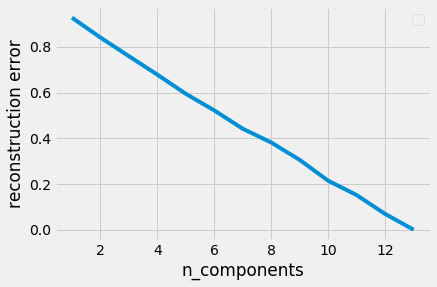

In [172]:
recons_error_list = choose_n_components_rac(range(1,len(df.columns)), X_train_trans, random_state_list, save=False, filename=None)

In [173]:
def rca_input(n, X_train, X_test, r):
    rca = GaussianRandomProjection(n_components=n, random_state=r)
    rca.fit(X_train)
    RCA_X_train = rca.transform(X_train)
    RCA_X_test = rca.transform(X_test)
    return RCA_X_train, RCA_X_test

In [175]:
RCA_X_train, RCA_X_test = rca_input(8, X_train_trans, X_test_trans,42)

2 0 0.16728771622162192 0.047515869140625
2 42 0.22766059584920667 0.05681276321411133
2 100 0.30064824517701105 0.04983711242675781
3 0 0.20391615462957446 0.06178903579711914
3 42 0.146502010593255 0.06578636169433594
3 100 0.16917818756945635 0.0478365421295166
4 0 0.18994536124018163 0.0657813549041748
4 42 0.14437763926105793 0.06777286529541016
4 100 0.19058520577855767 0.0817263126373291
5 0 0.08730904803566501 0.09667658805847168
5 42 0.1441280536937455 0.08771038055419922
5 100 0.15991624358405504 0.06976556777954102
6 0 0.13203594431507418 0.08770227432250977
6 42 0.16192485850674074 0.06279134750366211
6 100 0.10850734869691563 0.07375431060791016
7 0 0.11961403717104263 0.08821988105773926
7 42 0.10940386495815078 0.0817265510559082
7 100 0.07185479172025236 0.07816481590270996
8 0 0.09985751618506201 0.07951831817626953
8 42 0.21069901188272913 0.10148310661315918
8 100 0.037629056850347266 0.1171882152557373
9 0 0.08275443434850391 0.1584911346435547
9 42 0.08779244611009

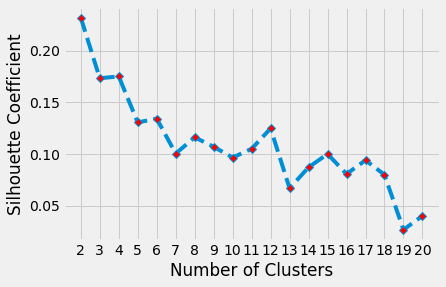

In [177]:
random_state_list=[0, 42, 100]
kmeans_kwargs = {
    "init": "k-means++",
      "n_init": 10,
        "max_iter": 300
      
   }

sihouette_rca_10 = sihouette(range(2,21), RCA_X_train, random_state_list,  **kmeans_kwargs)

C:\Users\april\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


KMeans(n_clusters=2, random_state=63918)

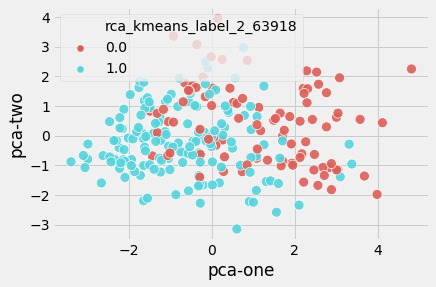

In [178]:
import random
r = random.randint(1, 100000)
tra, tes = rca_input(8, X_train_trans, X_test_trans,r)
plot_kmeans_cluster(2, tra, tes, r, "k-means++", "rca_kmeans_label_2_{r}".format(r=r))

C:\Users\april\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


KMeans(n_clusters=2, random_state=50725)

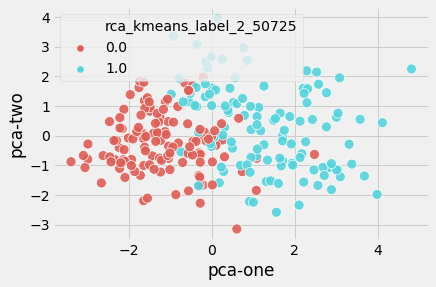

In [179]:
import random
r = random.randint(1, 100000)
tra, tes = rca_input(8, X_train_trans, X_test_trans,r)
plot_kmeans_cluster(2, tra, tes, r, "k-means++", "rca_kmeans_label_2_{r}".format(r=r))

C:\Users\april\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


KMeans(n_clusters=2, random_state=77919)

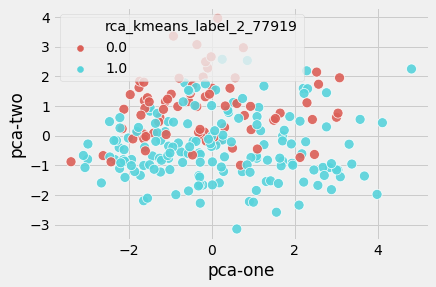

In [180]:
import random
r = random.randint(1, 100000)
tra, tes = rca_input(8, X_train_trans, X_test_trans,r)
plot_kmeans_cluster(2, tra, tes, r, "k-means++", "rca_kmeans_label_2_{r}".format(r=r))

C:\Users\april\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


KMeans(n_clusters=2, random_state=11723)

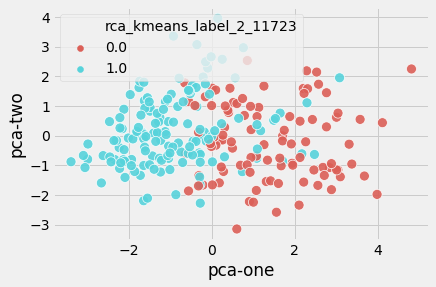

In [181]:
import random
r = random.randint(1, 100000)
tra, tes = rca_input(8, X_train_trans, X_test_trans,r)
plot_kmeans_cluster(2, tra, tes, r, "k-means++", "rca_kmeans_label_2_{r}".format(r=r))

2 0 5054.445298942015 5364.960756569961 0.021927356719970703
2 42 10115.127356043262 10736.158271299153 0.0468442440032959
2 100 15168.716862132787 16100.263235016624 0.028905391693115234
3 0 5038.671429799829 5506.189085104825 0.029880285263061523
3 42 10077.342859599656 11012.37817020965 0.024917125701904297
3 100 15116.068752285311 16518.621718200302 0.034055233001708984
4 0 4810.804798347366 5435.324651329413 0.06678128242492676
4 42 9823.7932563865 11072.832962350594 0.02292466163635254
4 100 14599.55582038204 16473.11537932818 0.06976675987243652
5 0 4743.343561808384 5524.865612467482 0.07919740676879883
5 42 9742.637947557107 11305.682048875302 0.03388619422912598
5 100 14547.292371675918 16891.85852365321 0.0801551342010498
6 0 4838.167019506933 5776.691267843082 0.060832977294921875
6 42 9832.927743571823 11709.976240244121 0.028855323791503906
6 100 14830.149248371075 17645.72199337952 0.06279325485229492
7 0 4819.9123621205235 5915.438808133723 0.053820133209228516
7 42 972

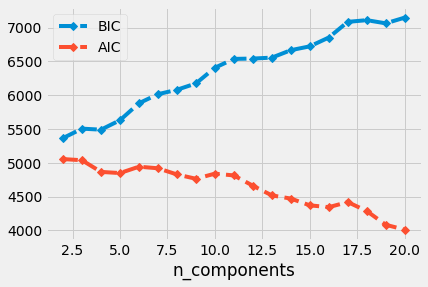

In [182]:
gmm_kwargs = {
    "init_params": "kmeans",
      "covariance_type": "full"
      
   }
aic_score, bic_score = choose_n_components_GMM(n_components = range(2, 21), X=RCA50_X_train, random_state_list=[0, 42, 100], **gmm_kwargs)

C:\Users\april\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


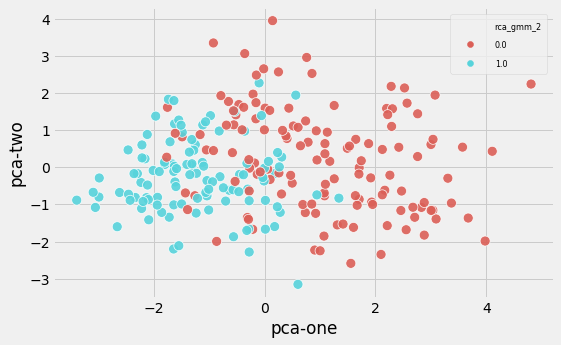

In [184]:
em_model_all_20 = plot_GMM_cluster(2, RCA_X_train, RCA_X_test,  42, 'rca_gmm_2', save=False, filename=None, plot=True, **gmm_kwargs)

In [153]:
def get_mse_rsa_sparse(n, X):
    transformer = random_projection.SparseRandomProjection(n_components=n)
    X_new = transformer.fit_transform(X)
    inverse_data = np.linalg.pinv(transformer.components_.T)
    reconstructed_data = X_new.dot(inverse_data)
    mse = mean_squared_error(reconstructed_data, X)
    return transformer, X_new, mse

In [157]:
transformer = random_projection.SparseRandomProjection(n_components=10)
X_new = transformer.fit_transform(X_train_trans)

In [160]:
X_new.shape

(32561, 10)

In [154]:
n_components = np.arange(1, 100)
mse = [get_mse_rsa_sparse(n, X_train_trans)[2]
          for n in n_components]

plt.plot(n_components, mse)
plt.legend(loc='best')
plt.xlabel('n_components')

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

In [ ]:
#### Feature Importance

In [111]:
#Loading libraries and read data
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm
import numpy as np
from random import sample



In [112]:
model_rf = RandomForestClassifier(n_jobs=-1, n_estimators = 200, min_samples_leaf = 20)
model_rf.fit(X_train[f], y_train)
for s in ['accuracy', 'roc_auc','precision', 'recall']:
    print ("model_rf_{s}:{a}".format(s = s, a = np.mean(cm_cv(model_rf, 3, X_train, y_train, s))))

    
feature_importance_rf = pd.DataFrame(pd.Series(model_rf.feature_importances_,index = X.columns.tolist()).sort_values(ascending=False),columns = ['coef']) 
feature_importance_rf

NameError: name 'f' is not defined

### Neural Network

In [211]:
config_data = {'adult':
        {
            'path': 'data/adult.csv',
            'sep': ',',
            'encoder': "OneHotEncoder",
            "features": ','.join(['workclass',
                                'education',
                                'marital-status',
                                'occupation',
                                'relationship',
                                'race',
                                'sex',
                                'native-country']),
                                 
             "target": "income"                    
            
        }
}

In [185]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN

model_config = {
    
    
    'MLPClassifier':
        {
            'model': MLPClassifier,
            'normalizer': False,
            'param_values':
                {
                    "hidden_layer_sizes": [32, 64, 128],
                    "max_iter": [100, 300]
                },
            'score_fn': 'f1_macro',
            "default_model_args":
            {
                "hidden_layer_sizes": 4,
                "max_iter": 300,

            }
        }
    
    
    
    
    }

In [186]:
X_train

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,...,pca_GMM_clusters_7,pca_GMM_clusters_2,pca_GMM_spherical_clusters_3,ica_kmeans_label_2,ica_GMM_clusters_2,rca_kmeans_label_2_63918,rca_kmeans_label_2_50725,rca_kmeans_label_2_77919,rca_kmeans_label_2_11723,rca_gmm_2
286,59,1,3,134,204,0,1,162,0,0.8,...,2,0,1,0,0,0,0,1,1,0
102,63,0,1,140,195,0,1,179,0,0.0,...,3,0,1,0,0,0,0,0,1,0
242,64,1,0,145,212,0,0,132,0,2.0,...,3,1,2,0,0,0,1,0,1,0
65,35,0,0,138,183,0,1,182,0,1.4,...,1,0,1,0,1,1,0,1,1,1
35,46,0,2,142,177,0,0,160,1,1.4,...,3,1,2,0,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,47,1,2,130,253,0,1,179,0,0.0,...,1,0,1,0,1,1,0,1,1,1
123,54,0,2,108,267,0,0,167,0,0.0,...,4,0,1,0,1,1,0,0,1,1
15,50,0,2,120,219,0,1,158,0,1.6,...,1,0,1,0,1,1,0,1,1,1
125,34,0,1,118,210,0,1,192,0,0.7,...,1,0,1,0,1,1,0,1,1,1


In [219]:
from model_train_eval import *
def fit(X_train, y_train, X_test, y_test, model, target, config, k, balancer=True, hypertune=False, test_size = 0.3, model_args=None, save=True, visualize=True):
    
    #X = df.loc[:, df.columns != target]
    #y = df.loc[:, df.columns == target]
    

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 42)
    
    if balancer:

        
        X_train, y_train = rebalance_data(X_train, y_train,strategy="Subsampling")
        
    
    if config[model]['normalizer']:
        print ('normalize data first!')
        X_train, X_test = normalizer(X_train, X_test)
        
    
    #print (X_train.shape)

    if hypertune:
        print (config[model])
        search_args = config[model]['param_values']
        model_fn =  config[model]['model']
        score_fn = config[model]['score_fn']
        start = time.time()
        results_dict = hyperparameter_sweep(model_fn, X_train, y_train, k, score_fn, search_args, strategy='gridsearch')
        classifier = results_dict['best_model']
        end = time.time()
        elapsed = end - start
        info = results_dict['results']
        
    else:
        model_fn = config[model]['model']
        #print (model_fn)
        if not model_args:
            model_args = config[model]['default_model_args']
        start = time.time()
        print ('start')
        classifier = fit_model(model_fn, model_args, X_train, y_train)
        print ('end')
        end = time.time()
        elapsed = end - start
        info = None
        
    print ('fit model finished')  
    
    result = {'classifier': classifier,
            'train_time_elapsed': elapsed,
           'info': info }

    print (result)
    
    
    if save:
        with open('model/{}.pickle'.format(model), 'wb') as handle:
            pickle.dump(result, handle)
            
            
    performance_result = evaluate(classifier, X_test, y_test, average='macro', save=True)
    
    if visualize:
        
        plot_learning_curve(classifier, X_train, y_train, ylim=(0.4, 1.01), cv=3, n_jobs=4, train_sizes=np.linspace(0.1, 1.0, 5))
    
        
    print ('plot finished')
    
        
    return {**result, **performance_result}

In [ ]:
# origin
config1 = config_data['adult']
features = config1['features'].split(',')
target = config1['target']
classifier_dict_origin = fit(X_train_trans, y_train, X_test_trans, y_test,  'MLPClassifier', target, model_config, k=3, hypertune=False, visualize=False)

In [222]:
# PCA
config1 = config_data['adult']
features = config1['features'].split(',')
target = config1['target']
classifier_dict_pca = fit(PCA_X_train, y_train, PCA_X_test, y_test,  'MLPClassifier', target, model_config, k=3, hypertune=False, visualize=False)

start


C:\Users\april\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\april\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


end
fit model finished
{'classifier': MLPClassifier(hidden_layer_sizes=64, max_iter=300), 'train_time_elapsed': 29.15612506866455, 'info': None}
roc_auc is 0.8971033924665828
              precision    recall  f1-score   support

       <=50K       0.94      0.80      0.86      7455
        >50K       0.56      0.83      0.67      2314

    accuracy                           0.80      9769
   macro avg       0.75      0.81      0.76      9769
weighted avg       0.85      0.80      0.82      9769

plot finished


In [223]:
# ICA
config1 = config_data['adult']
features = config1['features'].split(',')
target = config1['target']
classifier_dict_ica = fit(ICA_X_train, y_train, ICA_X_test, y_test,  'MLPClassifier', target, model_config, k=3, hypertune=False, visualize=False)

start


C:\Users\april\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\april\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


end
fit model finished
{'classifier': MLPClassifier(hidden_layer_sizes=64, max_iter=300), 'train_time_elapsed': 32.87389302253723, 'info': None}
roc_auc is 0.8760148908431864
              precision    recall  f1-score   support

       <=50K       0.93      0.77      0.84      7455
        >50K       0.52      0.82      0.64      2314

    accuracy                           0.78      9769
   macro avg       0.73      0.79      0.74      9769
weighted avg       0.83      0.78      0.79      9769

plot finished


In [228]:
# RCA
config1 = config_data['adult']
features = config1['features'].split(',')
target = config1['target']
classifier_dict_rca = fit(RCA_X_train, y_train, RCA_X_test, y_test,  'MLPClassifier', target, model_config, k=3, hypertune=False, visualize=False)

start


C:\Users\april\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\april\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


end
fit model finished
{'classifier': MLPClassifier(hidden_layer_sizes=64, max_iter=300), 'train_time_elapsed': 35.235127449035645, 'info': None}
roc_auc is 0.8846632662584555
              precision    recall  f1-score   support

       <=50K       0.94      0.77      0.84      7455
        >50K       0.53      0.84      0.65      2314

    accuracy                           0.78      9769
   macro avg       0.73      0.80      0.75      9769
weighted avg       0.84      0.78      0.80      9769

plot finished


In [227]:
# origin
config1 = config_data['adult']
features = config1['features'].split(',')
target = config1['target']
classifier_dict_origin = fit(X_train_trans, y_train, X_test_trans, y_test,  'MLPClassifier', target, model_config, k=3, hypertune=False, visualize=False)

start


C:\Users\april\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\april\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


end
fit model finished
{'classifier': MLPClassifier(hidden_layer_sizes=64, max_iter=300), 'train_time_elapsed': 35.65333867073059, 'info': None}
roc_auc is 0.8976224387523644
              precision    recall  f1-score   support

       <=50K       0.94      0.78      0.85      7455
        >50K       0.54      0.85      0.66      2314

    accuracy                           0.79      9769
   macro avg       0.74      0.81      0.76      9769
weighted avg       0.85      0.79      0.81      9769

plot finished


In [233]:
classifier_dict_origin

{'classifier': MLPClassifier(hidden_layer_sizes=64, max_iter=300),
 'train_time_elapsed': 35.65333867073059,
 'info': None,
 'f1': 0.7571361527358148,
 'precision': 0.7428146480216025,
 'recall': 0.8137018017062327,
 'accuracy': 0.7943494728221927,
 'roc_auc': 0.8976224387523644,
 'classification_report': '              precision    recall  f1-score   support\n\n       <=50K       0.94      0.78      0.85      7455\n        >50K       0.54      0.85      0.66      2314\n\n    accuracy                           0.79      9769\n   macro avg       0.74      0.81      0.76      9769\nweighted avg       0.85      0.79      0.81      9769\n'}

In [271]:
X_train_with_label = X_train[X_test.columns]

In [269]:
X_test.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'kmeans_cluster', 'kmeans_all_6', 'kmeans_all_20', 'GMM_all_7',
       'GMM_all_20', 'pca_kmeans_label_8', 'pca_kmeans_label_20',
       'pca_GMM_clusters_7', 'pca_GMM_clusters_30', 'ica_kmeans_label_30',
       'ica_GMM_clusters_30', 'ica_GMM_clusters_6', 'ica_kmeans_label_2',
       'rca_kmeans_label_2', 'rca_kmeans_label_30'],
      dtype='object')

In [286]:
scaler = StandardScaler()
X_train_trans_withclusters = scaler.fit_transform(X_train_with_label_one[X_test_with_label_one.columns])
X_test_trans_withclusters = scaler.transform(X_test_with_label_one)

In [287]:
# origin
config1 = config_data['adult']
features = config1['features'].split(',')
target = config1['target']
classifier_dict_origin = fit(X_train_trans_withclusters, y_train, X_test_trans_withclusters, y_test,  'MLPClassifier', target, model_config, k=3, hypertune=False, visualize=False)

start


C:\Users\april\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


end
fit model finished
{'classifier': MLPClassifier(hidden_layer_sizes=64, max_iter=300), 'train_time_elapsed': 34.87546229362488, 'info': None}
roc_auc is 0.7520368827775064
              precision    recall  f1-score   support

       <=50K       0.81      0.89      0.85      7455
        >50K       0.47      0.32      0.38      2314

    accuracy                           0.75      9769
   macro avg       0.64      0.60      0.61      9769
weighted avg       0.73      0.75      0.74      9769

plot finished


In [273]:
# origin
config1 = config_data['adult']
features = config1['features'].split(',')
target = config1['target']
classifier_dict_origin = fit(X_train_trans_withclusters, y_train, X_test_trans_withclusters, y_test,  'MLPClassifier', target, model_config, k=3, hypertune=False, visualize=False)

start


C:\Users\april\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\april\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


end
fit model finished
{'classifier': MLPClassifier(hidden_layer_sizes=64, max_iter=300), 'train_time_elapsed': 27.61596965789795, 'info': None}
roc_auc is 0.8638562576843952
              precision    recall  f1-score   support

       <=50K       0.92      0.78      0.84      7455
        >50K       0.52      0.78      0.62      2314

    accuracy                           0.78      9769
   macro avg       0.72      0.78      0.73      9769
weighted avg       0.82      0.78      0.79      9769

plot finished


In [274]:
X_train_with_label

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,pca_kmeans_label_8,pca_kmeans_label_20,pca_GMM_clusters_7,pca_GMM_clusters_30,ica_kmeans_label_30,ica_GMM_clusters_30,ica_GMM_clusters_6,ica_kmeans_label_2,rca_kmeans_label_2,rca_kmeans_label_30
19749,34,6,56460,11,9,2,5,5,4,0,...,2,9,6,27,2,17,0,0,0,21
1216,48,6,243631,15,10,2,3,0,0,1,...,6,19,4,14,8,28,5,1,1,4
27962,23,7,56402,15,10,2,10,0,4,1,...,1,6,2,1,15,24,3,1,0,19
23077,56,2,255406,11,9,0,4,1,4,0,...,3,12,1,12,0,25,3,1,0,16
10180,17,4,297246,1,7,4,9,3,4,0,...,7,0,3,28,21,14,1,1,0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,47,4,359461,9,13,2,3,0,4,1,...,1,10,2,1,20,24,3,1,1,13
5390,31,4,147215,2,8,0,8,4,4,0,...,7,0,3,25,17,29,1,1,0,21
860,18,4,216284,1,7,4,1,3,4,0,...,7,0,3,28,21,14,1,1,1,29
15795,50,6,54261,11,9,2,5,0,4,1,...,1,1,2,1,15,12,3,1,0,15


In [280]:
X_train_with_label.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'kmeans_cluster', 'kmeans_all_6', 'kmeans_all_20', 'GMM_all_7',
       'GMM_all_20', 'pca_kmeans_label_8', 'pca_kmeans_label_20',
       'pca_GMM_clusters_7', 'pca_GMM_clusters_30', 'ica_kmeans_label_30',
       'ica_GMM_clusters_30', 'ica_GMM_clusters_6', 'ica_kmeans_label_2',
       'rca_kmeans_label_2', 'rca_kmeans_label_30'],
      dtype='object')

In [282]:
categorical_columns=features+['kmeans_all_6', 'kmeans_all_20', 'GMM_all_7',
       'GMM_all_20', 'pca_kmeans_label_8', 'pca_kmeans_label_20',
       'pca_GMM_clusters_7', 'pca_GMM_clusters_30', 'ica_kmeans_label_30',
       'ica_GMM_clusters_30', 'ica_GMM_clusters_6', 'ica_kmeans_label_2',
       'rca_kmeans_label_2', 'rca_kmeans_label_30']

In [283]:
X_train_with_label_one = onehot_encoder(X_train_with_label, categorical_columns=categorical_columns)
X_test_with_label_one = onehot_encoder(X_test, categorical_columns=categorical_columns)

C:\Users\april\Anaconda3\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\april\CS7641_MachineLearning\assignment1\utils\encoder.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = encoders[column].fit_transform(df[column])


workclass
education
marital-status
occupation
relationship
race
sex
native-country
kmeans_all_6
kmeans_all_20
GMM_all_7
GMM_all_20
pca_kmeans_label_8
pca_kmeans_label_20
pca_GMM_clusters_7
pca_GMM_clusters_30
ica_kmeans_label_30
ica_GMM_clusters_30
ica_GMM_clusters_6
ica_kmeans_label_2
rca_kmeans_label_2
rca_kmeans_label_30
workclass
education
marital-status
occupation
relationship
race
sex
native-country
kmeans_all_6
kmeans_all_20
GMM_all_7
GMM_all_20
pca_kmeans_label_8
pca_kmeans_label_20
pca_GMM_clusters_7
pca_GMM_clusters_30
ica_kmeans_label_30
ica_GMM_clusters_30
ica_GMM_clusters_6
ica_kmeans_label_2
rca_kmeans_label_2
rca_kmeans_label_30


In [284]:
X_train_with_label_one

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,kmeans_cluster,workclass_0,workclass_1,workclass_2,...,rca_kmeans_label_30_20,rca_kmeans_label_30_21,rca_kmeans_label_30_22,rca_kmeans_label_30_23,rca_kmeans_label_30_24,rca_kmeans_label_30_25,rca_kmeans_label_30_26,rca_kmeans_label_30_27,rca_kmeans_label_30_28,rca_kmeans_label_30_29
0,34,56460,9,0,2179,12,2,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,48,243631,10,7688,0,40,6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,23,56402,10,0,0,30,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,56,255406,9,0,0,40,3,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17,297246,7,0,0,9,7,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22787,47,359461,13,0,0,40,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22788,31,147215,8,0,0,21,7,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22789,18,216284,7,0,0,20,7,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22790,50,54261,9,0,0,84,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_train_with_label_one, X_test_with_label_one, y_train, y_test = train_test_generate(pd.concat([X_train_with_label, X_test_with_label], 'income',  encoder='OneHotEncoder', features=['workclass',
                                'education',
                                'marital-status',
                                'occupation',
                                'relationship',
                                'race',
                                'sex',
                                'native-country'], test_size=0.3)

In [ ]:
def fit_eval(dataset, model, visualize=True, hypertune=False):
    config1 = config_data[dataset]
    path = config1['path']
    sep = config1['sep']
    features = config1['features'].split(',')
    target = config1['target']
    data = pd.read_csv(path, sep=sep)
    
    print ('data loaded successfully')
    X_train, X_test, y_train, y_test = train_test_generate(data, target=target, features=features, encoder=config1['encoder'])
    print ('-------------------------------------------------')
    print ('start to train model {}'.format(model))
    classifier_dict = fit( X_train, y_train, X_test, y_test, model, target, model_config, k=3, hypertune=hypertune, visualize=visualize)

In [ ]:
 finish_training = []
    for key in model_config:
        
        if key not in finish_training:
            fit_eval(args.dataset, key)
            finish_training.append(key)